In [ ]:
#!pip install tensorflow==1.*
#!pip install keras==2.1.6

In [ ]:
#%tensorflow_version 1.3.0
#import tensorflow as tf
#print(tf.__version__)

2.4.3


In [ ]:
import os
import sys
import json
import skimage.io
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!git clone --quiet "https://github.com/matterport/Mask_RCNN.git"

In [ ]:
%%capture
!unzip "/content/drive/MyDrive/crane_handle_.zip" -d "/content/Mask_RCNN"

In [ ]:
ROOT_DIR = os.path.abspath("../../content/Mask_RCNN")

In [ ]:
!pip install -r ./Mask_RCNN/requirements.txt #change h5py==2.10.0 tensorflow==1.13.1 keras==2.0.8

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 92.6 MB 66 kB/s 
     |████████████████████████████████| 276 kB 42.6 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 367 kB 45.2 MB/s 
     |████████████████████████████████| 3.2 MB 34.7 MB/s 
     |████████████████████████████████| 154 kB 49.4 MB/s 
     |████████████████████████████████| 391 kB 50.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uni

In [ ]:
os.listdir(ROOT_DIR)

In [ ]:
sys.path.append(ROOT_DIR)

In [ ]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/Mask_RCNN']

In [ ]:
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
#Path to trained weight file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

#Dir to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
#Configurations

class CustomConfig(Config):
  """
  Building configuration for the crane datasets. 
  from base Config class and overrides some values.
  """

  #configuration name
  NAME = "object"

  IMAGES_PER_GPU = 2 #TODO: Change to 2 for training and 1 for inference

  NUM_CLASSES = 1 + 1 #background + crane

  #Number of training steps per epoch
  STEPS_PER_EPOCH = 20

  #Skip detection with < 80% confidence 
  DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class CustomDataset(utils.Dataset):

  def load_custom(self, dataset_dir, subset):
    """
    Load a subset of the crane dataset

    Args:
    dataset_dir: root directory of the dataset
    subset: the subset of the dataset to load either train or val

    Return:
    None
    """

    #Add classes, since we only have oone class
    self.add_class("object", 1, "crane handle")

    #train or validation dataset
    assert subset in ['train', 'val']
    dataset_dir = os.path.join(dataset_dir, subset)

    #Load annotations
    #since we only care about the x and y coordinate of each regions
    annotations1 = json.load(open(os.path.join(dataset_dir, "Crane_json.json")))

    #print annotations
    annotations = list(annotations1.values()) #we don't need the dictionary keys

    #skipping unannotated images
    annotations = [a for a in annotations if a['regions']]

    #add images
    for a in annotations:
      #get the x, y coordinates of points of the polygon that makes up the
      #outline of each object instances

      polygons = [r['shape_attributes'] for r in a['regions']]
      #name is from the header of the labeling tool
      objects = [s['region_attributes']['name'] for s in a['regions']]
      #print("objects", objects)

      name_dict = {"crane handle" : 1}
      num_ids = [name_dict[a] for a in objects]

      #print("numids", num_ids)

      image_path = os.path.join(dataset_dir, a['filename'])
      image = skimage.io.imread(image_path)
      height, width = image.shape[:2]

      self.add_image(
          "object",
          image_id = a['filename'],
          path = image_path,
          width = width,
          height = height,
          polygons = polygons,
          num_ids = num_ids
      )

  def load_mask(self, image_id):
    """
    It generate instance mask for an image

    Args:
    image_id: 

    Returns:
    mask: a boll array of shape [heaight, width, instance count] with one mask 
    per image
    class_ids: a 1D array of class IDs of the instance masks.
    """

    # if not a crane dataset image, delegate to parent class
    image_info = self.image_info[image_id]
    if image_info['source'] != "object":
      return super(self.__class__, self).load_mask(image_id)

    #convert polygons to a bitmap mask of shape
    info = self.image_info[image_id]
    if info["source"] != "object":
      return super(self.__class__, self).load_mask(image_id)
    num_ids = info['num_ids']
    mask = np.zeros([info['height'], info["width"], len(info['polygons'])],
                    dtype=np.uint8)
    for i, p in enumerate(info['polygons']):
      rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
      mask[rr, cc, i] = 1

    #return mask and array of class IDs of each instances
    num_ids = np.array(num_ids, dtype=np.int32)
    return mask, num_ids

  def image_reference(self, image_id):
    """
    Returns the path of an image
    """

    info = self.image_info[image_id]
    if info['source'] == "object":
      return info['path']
    
    else:
      super(self.__class__, self).images_reference(image_id)


In [ ]:
def train(model, dataset_dir):
  """
  Train the model
  """

  #Training dataset
  dataset_train = CustomDataset()
  dataset_train.load_custom(dataset_dir, "train")
  dataset_train.prepare()

  #validation dataset
  dataset_val = CustomDataset()
  dataset_val.load_custom(dataset_dir, "val")
  dataset_val.prepare()

  print("Training network ahead:")
  model.train(dataset_train, dataset_val,
              learning_rate = config.LEARNING_RATE,
              epochs = 5,
              layers = 'heads')

In [ ]:
def color_splash(image, mask):

  """
  Apply color splah effect.
  
  Args:
  image: RGB image i.e [heigh, width, 3]
  mask: instance segmentation mask [height, width, instance count]

  Returns:
  splashed image 
  """

  #make gray scale of the image
  gray = skimge.color.gray2rgb(skimage.color.rgb2gray(image)) * 255

  #treating all instances as one, so collapes teh into one
  mask = (np.sum(mask, -1, keepdims=True) >= 1)

  #copy color pixels fromthe original color image where the mask is set
  if mask.shape[0] > 0:
    splash = np.where(mask, image, gray).astype(np.uint8)
  else:
    splash = gray
  return splash

In [ ]:
def detect_and_color_splash(model, image_path=None, video_path=None):
  assert image_path or video_path
 
  # Image or video?
  if image_path:
    # Run model detection and generate the color splash effect
    print("Running on {}".format(args.image))
    
    # Read image
    image = skimage.io.imread(args.image)

    # Detect objects
    r = model.detect([image], verbose=1)[0]

    # Color splash
    splash = color_splash(image, r['masks'])

    # Save output
    file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
    skimage.io.imsave(file_name, splash)

  elif video_path:
    import cv2
    # Video capture
    vcapture = cv2.VideoCapture(video_path)
    width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = vcapture.get(cv2.CAP_PROP_FPS)
    
    # Define codec and create video writer
    file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
    vwriter = cv2.VideoWriter(file_name,
                              cv2.VideoWriter_fourcc(*'MJPG'),
                              fps, (width, height))
    count = 0
    success = True
    while success:
      print("frame: ", count)
      # Read next image
      success, image = vcapture.read()
      if success:
          # OpenCV returns images as BGR, convert to RGB
          image = image[..., ::-1]
          # Detect objects
          r = model.detect([image], verbose=0)[0]
          # Color splash
          splash = color_splash(image, r['masks'])
          # RGB -> BGR to save image to video
          splash = splash[..., ::-1]
          # Add image to video writer
          vwriter.write(splash)
          count += 1
    vwriter.release()
    print("Saved to ", file_name)

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode='training', config=config,
                          model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH

if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
... done downloading pretrained model!


In [ ]:
train(model=model, dataset_dir= os.path.join(ROOT_DIR, "crane_handle_"))

In [ ]:
!cp "/content/Mask_RCNN/logs/object20211008T2330/mask_rcnn_object_0004.h5" "/content/drive/MyDrive/Colab Notebooks"

In [ ]:
!nvidia-smi

Fri Oct  8 22:23:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Inference

In [ ]:
import os
import sys
import random
import math
import re, time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
%matplotlib inline

In [ ]:
ROOT_DIR = os.path.abspath("../../content/Mask_RCNN")

In [ ]:
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.visualize import display_images
from mrcnn import model as modellib, utils
from mrcnn.model import log
from mrcnn.config import Config

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
CUSTOM_DIR = os.path.join(ROOT_DIR, "crane_handle_")
INFERENCE_IMG_PATH = "/content/Mask_RCNN/crane_handle_/val/33f5a133-516_crane.jpg" #path to the image that will be used for inference
WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/mask_rcnn_object_0004.h5" #path to the last trained weight

config = CustomConfig()

In [ ]:
"""
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
"""
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """
    Return a matplotlib axes array to be used in all visulizations in the notebook
    """

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()

NameError: ignored

In [ ]:
model = modellib.MaskRCNN(mode='inference', model_dir= 'MODEL_DIR',
                         config=config)

AttributeError: ignored

In [ ]:
weights_path = WEIGHTS_PATH
model.load_weights(weights_path, by_name=True)

image ID: object.ad3fa38c-329_crane.jpg (31) /content/Mask_RCNN/crane_handle_/val/ad3fa38c-329_crane.jpg
1
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  232.00000  max:  878.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


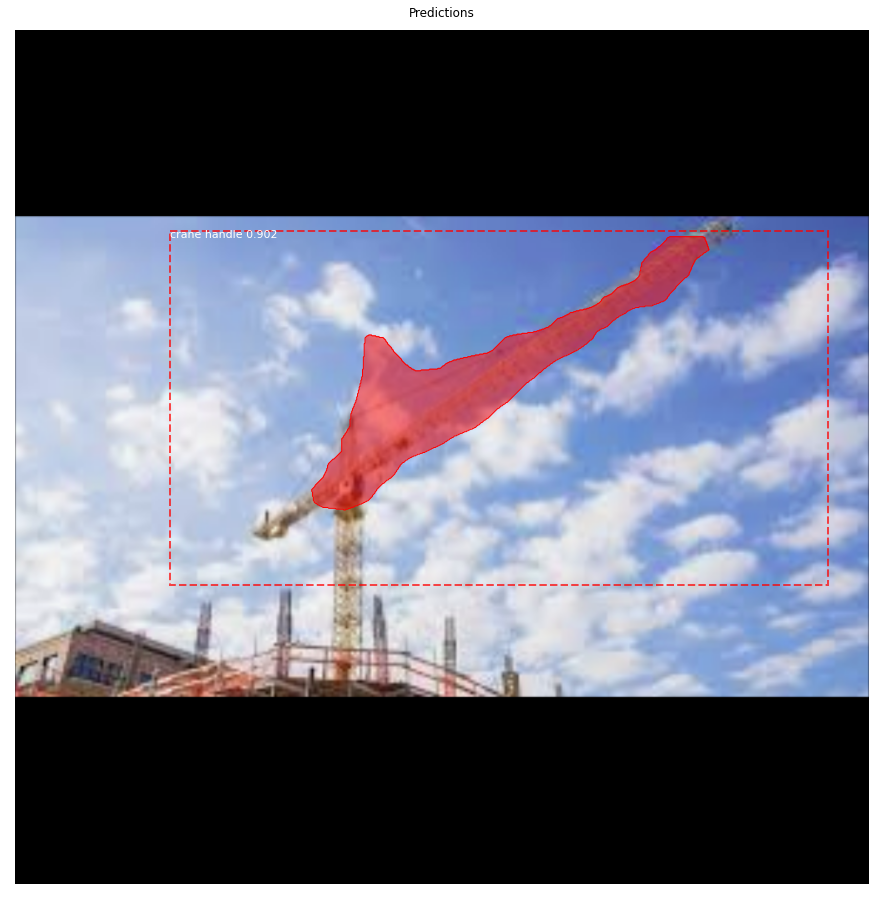

In [ ]:
#run inference on the test images
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
                            dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info['source'], info['id'], image_id,
                                       dataset.image_reference(image_id)))

#run object detection
print(len([image]))
results = model.detect([image], verbose=1)

#Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
#run inference on a single image
from PIL import Image

img = Image.open(INFERENCE_IMG_PATH)
if img.mode == "RGBA":
  b = Image.new("RGB", img.size, (255, 255, 255))
  b.paste(img, mask = img.split()[3])
  b.save(os.path.join(ROOT_DIR, "sample.jpg"), "JPEG")
  image1 = mpimg.imread(os.path.join(ROOT_DIR, "sample.jpg"))
else:
  image1 = mpimg.imread(INFERENCE_IMG_PATH)

print(len([image1]))
result1 = model.detect([image1], verbose=1)

ax = get_ax(1)
r1 = result1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset.class_names, r1['scores'], ax=ax,
                            title="Predictions")


1


NameError: ignored

[REF_1](https://www.youtube.com/watch?v=t1MrzuAUdoE&t=1160s)

[RER_2](https://thebinarynotes.com/how-to-train-mask-r-cnn-on-the-custom-dataset/)